# RUL prediction based on synthetic training data
In this notebook we will perform RUL prediction on CMAPSS data, but instead of using the original data we use a synthetic variant. The generation of synthetic data is performed in [this notebook](). The baseline and some introduction on RUL prediction is found in [this notebook]().

In [1]:
# import various modules and packages
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [2]:
# load the synthetic data as training data
train = pd.read_csv('./CMAPSS/Synthetic/SDV_FD001_RUL.csv')
train = train.drop('Unnamed: 0', axis=1)

# include all columns apart from RUL
col_names = train.columns[:-1]

# read data
test_data = pd.read_csv(('./CMAPSS/test_FD001.txt'), sep='\s+', header=None, names=col_names)
test_labels = pd.read_csv(('./CMAPSS/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

# show synthetic data
train.head(10)

,unit_nr,timecycle,ops_set1,ops_set2,ops_set3,sens_1,sens_2,sens_3,sens_4,sens_5,...,sens_13,sens_14,sens_15,sens_16,sens_17,sens_18,sens_19,sens_20,sens_21,RUL
0,5739,1,-0.000009,-0.000047,100.0,518.67,642.029516,1601.878441,1406.723414,14.62,...,2388.117848,8143.752722,8.448036,0.03,394,2388,100.0,38.780177,23.324110,92
1,5739,2,0.000219,0.000098,100.0,518.67,642.680934,1593.141883,1418.469407,14.62,...,2388.126903,8142.461136,8.441423,0.03,393,2388,100.0,38.826905,23.229579,92
2,5739,3,0.000546,0.000220,100.0,518.67,642.236239,1593.504174,1412.359347,14.62,...,2388.073125,8171.417231,8.442146,0.03,394,2388,100.0,38.911050,23.273312,106
3,5739,4,0.000391,0.000030,100.0,518.67,643.214563,1591.470492,1404.252749,14.62,...,2388.147953,8156.696650,8.454145,0.03,393,2388,100.0,38.898436,23.196215,113
4,5739,5,0.000058,0.000131,100.0,518.67,642.923353,1584.848283,1414.392896,14.62,...,2388.095147,8133.926311,8.445735,0.03,395,2388,100.0,38.812469,23.352205,190
5,5739,6,-0.000443,0.000147,100.0,518.67,642.858099,1586.965798,1411.238262,14.62,...,2388.066961,8135.834762,8.428135,0.03,394,2388,100.0,39.045554,23.314517,147
6,5739,7,0.001550,0.000121,100.0,518.67,643.058138,1592.322154,1411.560693,14.62,...,2388.132106,8161.199360,8.464603,0.03,394,2388,100.0,38.794430,23.242255,113
7,5739,8,0.000642,0.000147,100.0,518.67,642.819455,1595.619789,1402.413397,14.62,...,2388.098234,8161.153376,8.435394,0.03,395,2388,100.0,38.803337,23.280725,86
8,5739,9,-0.000122,-0.000150,100.0,518.67,642.805701,1585.236941,1410.769015,14.62,...,2388.121988,8143.752722,8.435166,0.03,394,2388,100.0,38.584315,23.221440,139
9,5739,10,-0.000745,-0.000151,100.0,518.67,641.762424,1584.805348,1412.319717,14.62,...,2388.154559,8150.767261,8.441474,0.03,394,2388,100.0,38.843819,23.247566,44


In [3]:
# Compute Remaining Useful Life (RUL) for each index (engine)
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["timecycle"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["timecycle"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

# train = add_remaining_useful_life(train)

In [4]:
# Preprocess the data, remove constant columns, indexes and operational settings.
print("Train set after removal of constant values:")
const_cols = ['sens_1', 'sens_5', 'sens_6', 'sens_10', 'sens_16', 'sens_18', 'sens_19']

indexes = ["unit_nr", "timecycle"]
op_settings = ["ops_set1", "ops_set2", "ops_set3"]

cols_to_drop = indexes + op_settings + const_cols

train = train.drop(cols_to_drop, axis=1)
train

Train set after removal of constant values:


,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21,RUL
0,642.029516,1601.878441,1406.723414,553.352686,2388.096652,9094.412898,47.797033,520.781384,2388.117848,8143.752722,8.448036,394,38.780177,23.324110,92
1,642.680934,1593.141883,1418.469407,553.024115,2388.096801,9055.622415,47.745525,520.694747,2388.126903,8142.461136,8.441423,393,38.826905,23.229579,92
2,642.236239,1593.504174,1412.359347,553.172221,2388.121271,9065.242941,47.279822,521.467434,2388.073125,8171.417231,8.442146,394,38.911050,23.273312,106
3,643.214563,1591.470492,1404.252749,553.516815,2388.119636,9041.787063,47.848000,521.662643,2388.147953,8156.696650,8.454145,393,38.898436,23.196215,113
4,642.923353,1584.848283,1414.392896,553.689624,2388.130687,9053.955416,47.634401,521.816848,2388.095147,8133.926311,8.445735,395,38.812469,23.352205,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18559,643.252017,1600.225759,1399.076567,553.522936,2388.136348,9060.275885,47.723467,520.677940,2388.161698,8182.248015,8.445993,394,38.816103,23.349392,134
18560,642.994982,1590.523119,1412.329469,554.143724,2388.114652,9083.274141,47.677522,521.463257,2388.130843,8137.785926,8.434002,393,38.711940,23.289705,72
18561,643.031966,1590.427387,1402.643325,552.603449,2388.116665,9066.667995,47.910360,521.271510,2388.111676,8132.642234,8.432541,393,38.847330,23.213170,109
18562,643.090927,1590.123908,1405.088953,553.461061,2388.075253,9086.305867,47.528594,521.814981,2388.084854,8143.752722,8.407107,392,38.882644,23.199962,132


# Prediction!

In [5]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [6]:
# remove RUL from training data, split
train_data = train.drop('RUL', axis=1) # data without constants
train_labels = train.pop('RUL') # RUL values

# Since the true RUL values for the test set are only provided for the last time cycle of each engine, 
# the test set is subsetted to represent the same
test_data = test_data.groupby('unit_nr').last().reset_index().drop(cols_to_drop, axis=1)

# # check whether RUL and constant columns removed
# X_test

In [7]:
rf = RandomForestRegressor(n_estimators= 300, max_features = "sqrt",
                                     n_jobs = -1, random_state = 38)

rf.fit(train_data, train_labels)

# predict and evaluate
pred_train = rf.predict(train_data)
evaluate(pred_train, train_labels, 'train')

pred_test = rf.predict(test_data)
evaluate(pred_test, test_labels)

train set RMSE:12.620169197110455, R2:0.6570714251810783
test set RMSE:47.4012598871474, R2:-134.34054936232997


## Using the clipped and scaled model:

In [8]:
train_data_clipped = train_data.clip(upper=125)
train_labels_clipped = train_labels.clip(upper=125)

# scaling the test and training data
scaler = StandardScaler()
train_data_clipped_scaled = scaler.fit_transform(train_data_clipped)
# train_labels_clipped_scaled = scaler.fit_transform(train_labels_clipped)

test_data_scaled = scaler.transform(test_data)
# test_labels_scaled = scaler.transform(test_labels)

# creating the RFR
rf_clip = RandomForestRegressor(n_estimators= 300, max_features = "sqrt",
                                 n_jobs = -1, random_state = 38)
rf_clip.fit(train_data_clipped_scaled, train_labels_clipped)

print("Predicting with clipped training data that is scaled, without clipping test data:")
# predict and evaluate
pred_train = rf_clip.predict(train_data_clipped_scaled)
evaluate(pred_train, train_labels_clipped, 'train')

pred_test = rf_clip.predict(test_data_scaled)
evaluate(pred_test, test_labels)

# And now when also clipping the test data
print("\nClipping also the test data:")
test_data_clipped = test_data.clip(upper=125)
test_data_clipped_scaled = scaler.transform(test_data_clipped)
test_labels_clipped = test_labels.clip(upper=125)

rf_clip2 = RandomForestRegressor(n_estimators= 300, max_features = "sqrt",
                                 n_jobs = -1, random_state = 38)

rf_clip2.fit(train_data_clipped_scaled, train_labels_clipped)

# predict and evaluate
pred_train = rf_clip2.predict(train_data_clipped_scaled)
evaluate(pred_train, train_labels_clipped, 'train clipped')

pred_test = rf_clip2.predict(test_data_clipped_scaled)
evaluate(pred_test, test_labels_clipped)

Predicting with clipped training data that is scaled, without clipping test data:
train set RMSE:10.476920822480778, R2:0.650403012997474
test set RMSE:40.536023440062955, R2:-14.986786606363447

Clipping also the test data:
train clipped set RMSE:10.476920822480778, R2:0.650403012997474
test set RMSE:39.45005783265723, R2:-14.14168410999716


# Discussion
First of all, we see that the RMSE is way higher than expected. As we were struggling at first with finding a synthetic data generator that can correctly model timeseries, we expect this may be a cause. To check this hypothesis, we will plot the difference sensors compared to RUL.

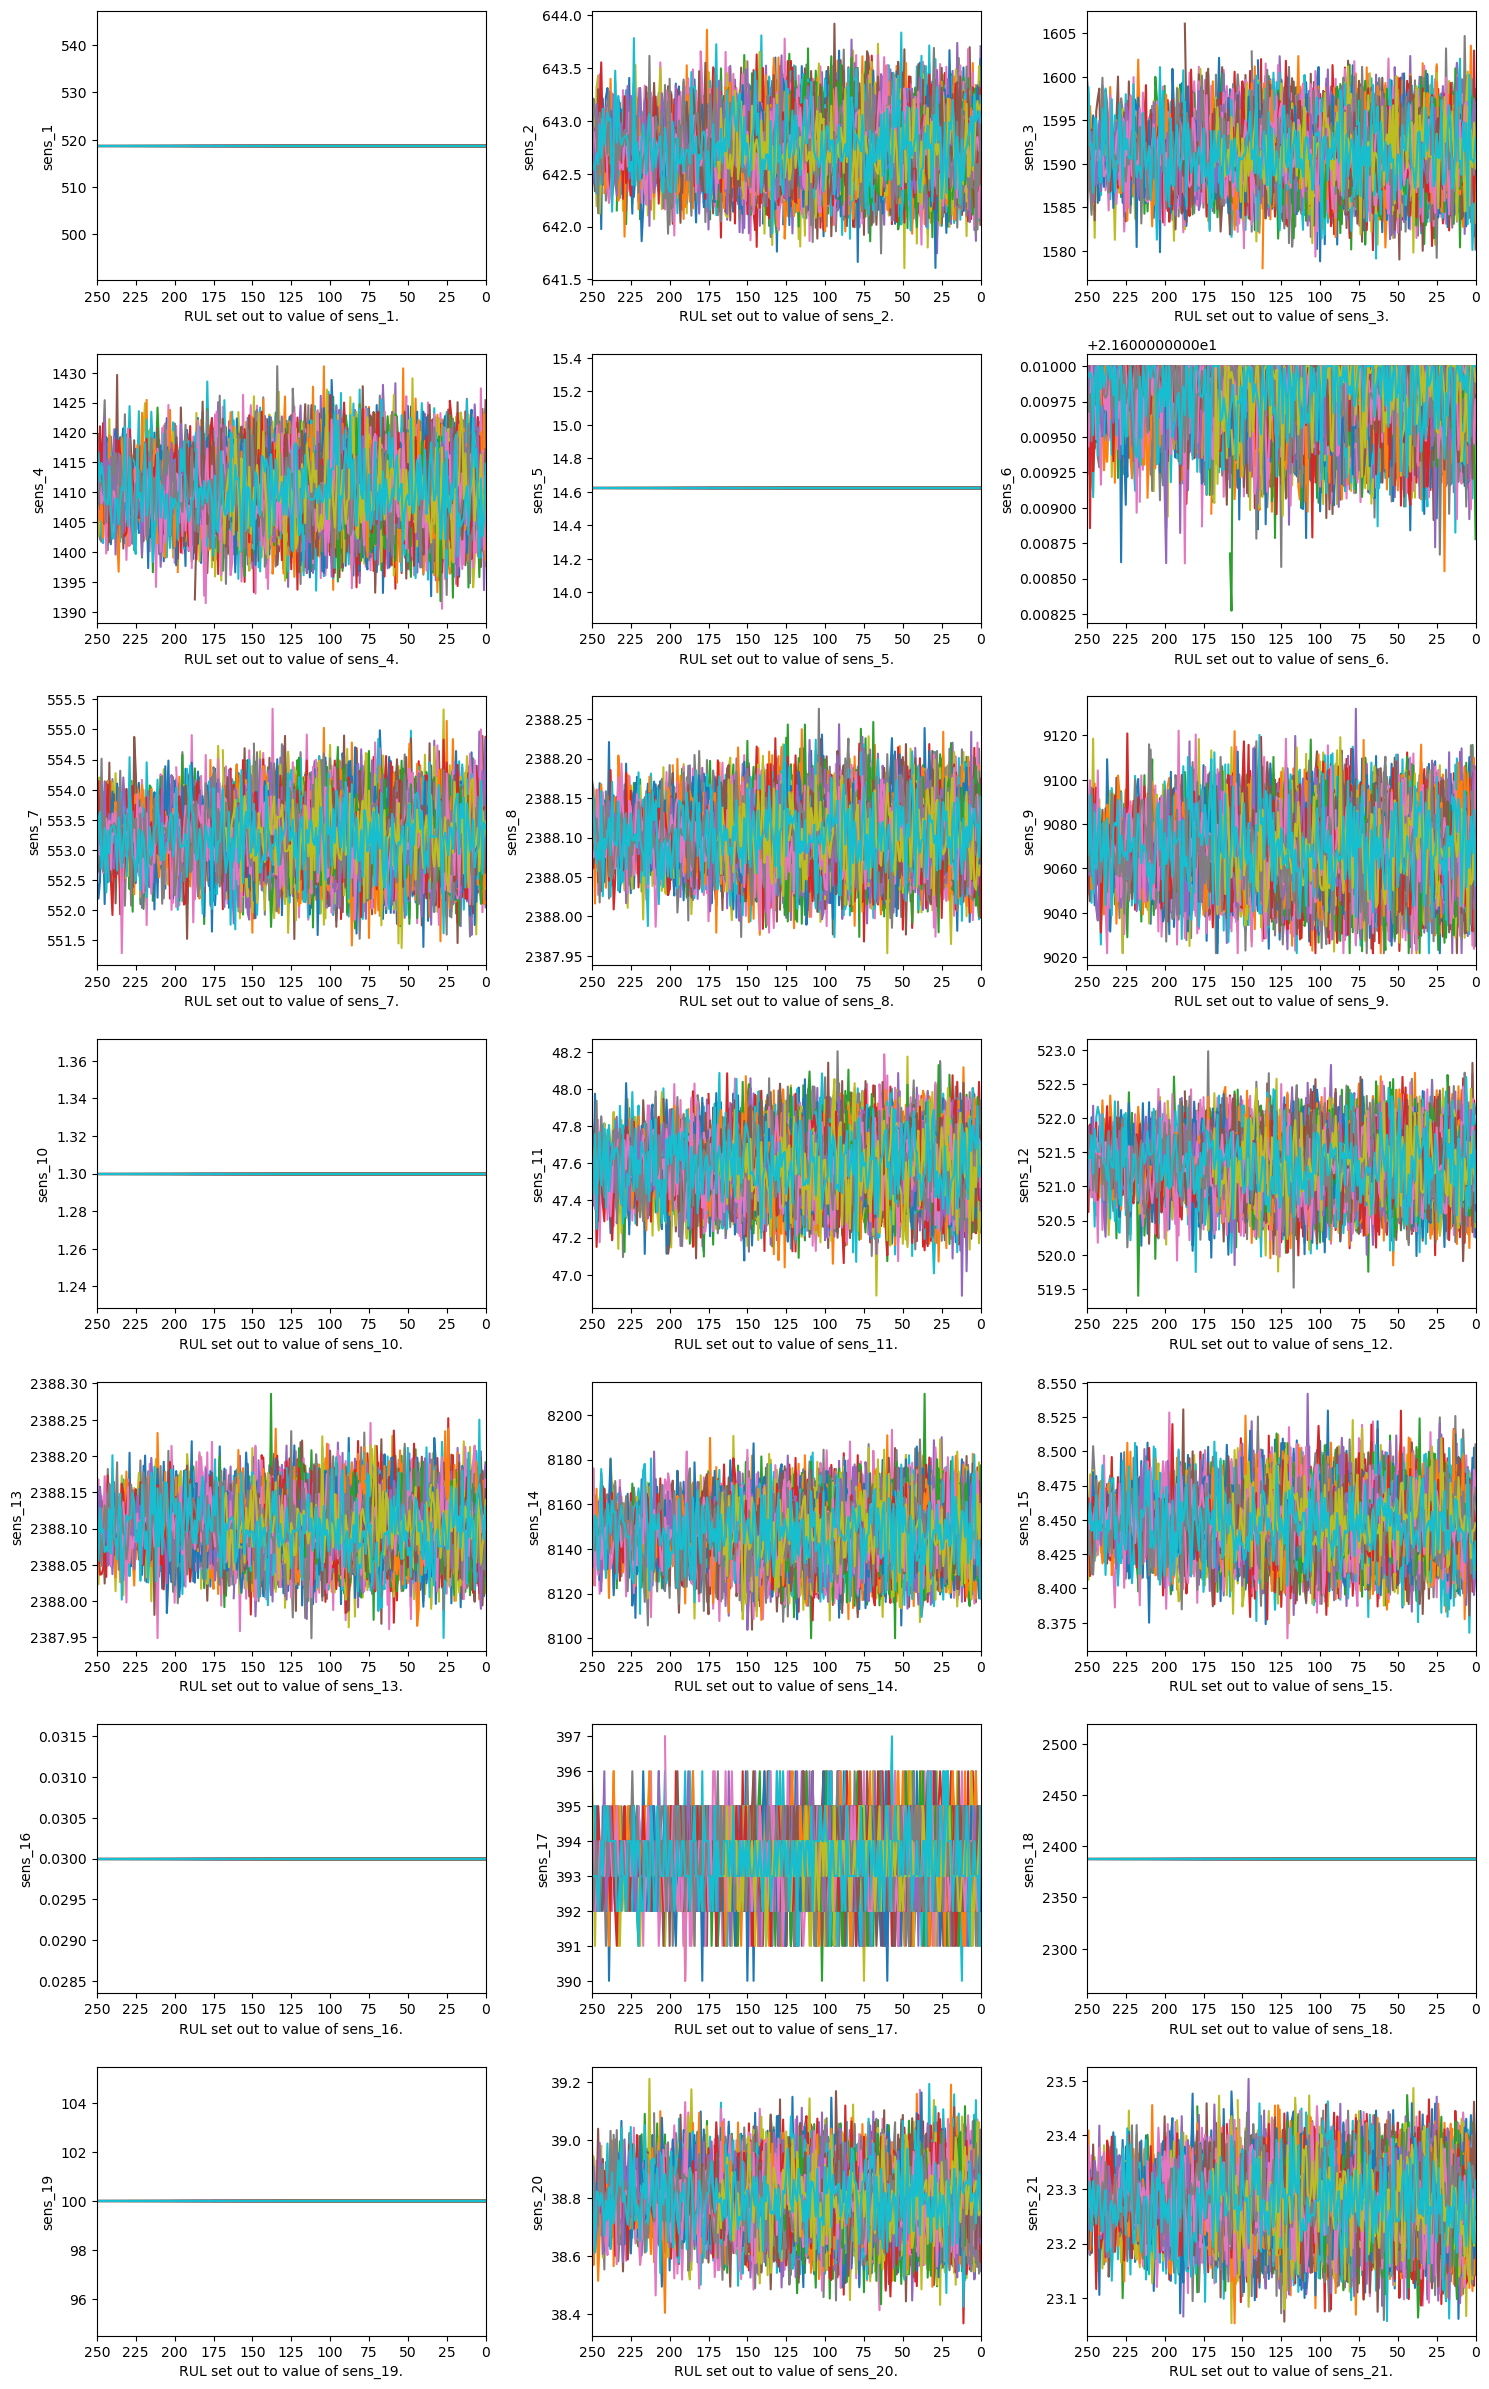

In [9]:
# reload synthetic data
train = pd.read_csv('./CMAPSS/Synthetic/SDV_FD001_RUL.csv')
train = train.drop('Unnamed: 0', axis=1)
train = add_remaining_useful_life(train)

# create list with sensors
sensors = []
for i in range(1,22):
    sensors.append(f"sens_{i}")

# create plot
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15, 24))

for i, sensor_idx in enumerate(sensors):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    # plot each sensor in own graph
    for j in train['unit_nr'].unique():
        ax.plot('RUL', sensor_idx, data=train[train['unit_nr']==j])
    
    # graphics
    ax.set_xlim(250, 0)
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(sensor_idx)
    ax.set_xlabel(f'RUL set out to value of {sensor_idx}.')

plt.tight_layout()
plt.savefig('./Figures/SensorsSDV')

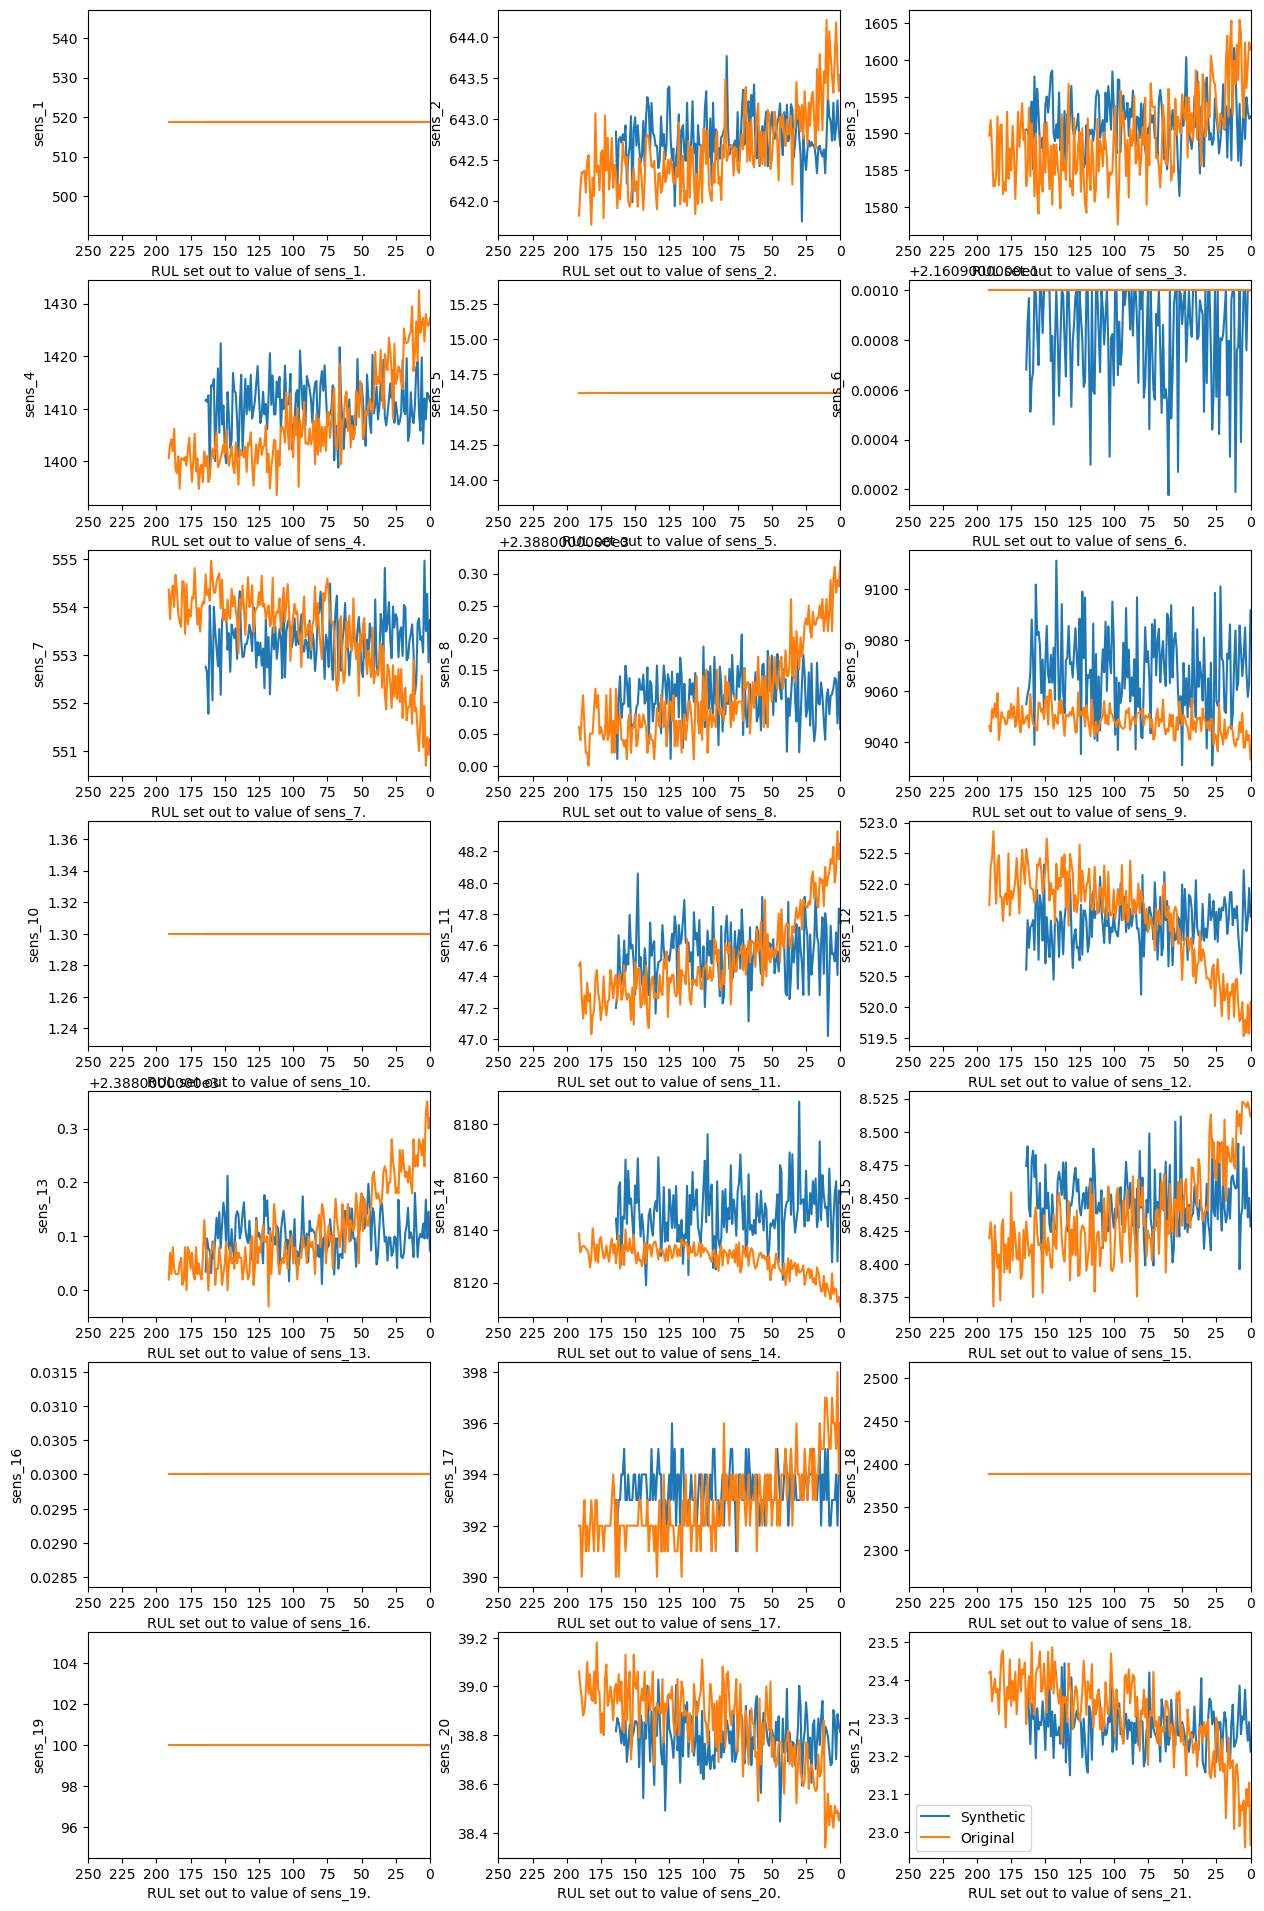

In [10]:
# create plot
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15, 24))

# Compute Remaining Useful Life (RUL) for each index (engine)
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["timecycle"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["timecycle"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

syn_data = train
data = pd.read_csv(('./CMAPSS/train_FD001.txt'), sep='\s+', header=None, names=col_names)
data = add_remaining_useful_life(data)

for i, sensor_idx in enumerate(sensors):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    # plot each sensor in own graph
    ax.plot('RUL', sensor_idx, data=syn_data[syn_data['unit_nr']==297], label='Synthetic')
    ax.plot('RUL', sensor_idx, data=data[data['unit_nr']==1], label='Original')
    
    # graphics
    ax.set_xlim(250, 0)
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(sensor_idx)
    ax.set_xlabel(f'RUL set out to value of {sensor_idx}.')

plt.legend()
# plt.show()
plt.savefig('./Figures/Syn-vs-Original')

# Export exploratory data analysis to csv files

In [5]:
train = pd.read_csv('./CMAPSS/Synthetic/SDV_FD001_RUL.csv')
syn_data = train.drop('Unnamed: 0', axis=1)
syn_data = syn_data.drop('RUL', axis=1)

syn_description = syn_data.describe()
syn_description
syn_description.T.to_csv("./CMAPSS/Synthetic/SDV_ExplorData.csv", float_format="{:.5f}".format)

In [7]:
syn_description.T

,count,mean,std,min,25%,50%,75%,max
unit_nr,18564.0,52300.959491,3.022424e+04,297.000000,20604.000000,57382.000000,75683.000000,99455.000000
timecycle,18564.0,101.884292,6.972395e+01,1.000000,47.000000,93.000000,141.000000,362.000000
ops_set1,18564.0,-0.000005,1.011339e-03,-0.003940,-0.000668,-0.000009,0.000660,0.004212
ops_set2,18564.0,0.000004,1.485497e-04,-0.000590,-0.000093,0.000002,0.000100,0.000584
ops_set3,18564.0,100.000000,0.000000e+00,100.000000,100.000000,100.000000,100.000000,100.000000
sens_1,18564.0,518.670000,0.000000e+00,518.670000,518.670000,518.670000,518.670000,518.670000
sens_2,18564.0,642.752021,2.856391e-01,641.606238,642.563708,642.741310,642.940499,643.919006
sens_3,18564.0,1591.245154,3.321873e+00,1577.999235,1589.167107,1590.986394,1593.400952,1606.104940
sens_4,18564.0,1410.282246,5.296097e+00,1390.250104,1406.853930,1410.020844,1413.857345,1431.071379
sens_5,18564.0,14.620000,3.552809e-15,14.620000,14.620000,14.620000,14.620000,14.620000
